# Pneumonia Detection from X-Ray images

## Introduction

- *Objective*: Detect pneumonia from X-Ray images using Machine Learning
- *Datasets*: Train, Validation and Test sets of JPEG images

The objective of this project is to develop a Machine Learning model to detect pneumonia from X-Ray images.

We will use these 3 datasets: Train, Validation and Test. 

Each containing JPEG images categorized as either normal or pneumonia-affected. 

The following steps outline our approach to achieve this goal.

# Steps

1. Data Loading and Exploration
2. Data Preprocessing
3. Feature Extraction
4. Model Training
5. Model Evaluation
6. Results and Visualization
7. Conclusion

# I. Data Loading & Exploration

### Import necessary libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

### Define the directories for the datasets

*(load datasets and explore its structure)*

In [2]:
# Define paths
base_dir = "../chest_Xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

### Initialize ImageDataGenerator for data augmentation

(ImageDataGenerator is a class of Keras API for generating batches of image data with realtime data augmentation.)

Image preprocessing is the process of manipulating raw image data into a usable and meaningful format

It allows you to eliminate unwanted distortions and enhance specific qualities essential for computer vision applications

Preprocessing is a crucial first step to prepare image data before feeding it into machine learning models


Normalization: Adjust the intensity values of pixels to a desired range, often between 0 and 1. This can improve the performance of machine learning models.

*/train_datagen/*

**rescale**: rescale image pixel values from a range of [0, 255] to [0, 1]

common practice to normalize pixel values for neural network inputs to improve convergence

**flip**: flip image horizontally. Useful for augmenting image data because it creates new examples from existing images

====================================================================================

*/val_test_datagen/*

scale the pixel values from [0, 255] to [0, 1]. 

No other augmentations are applied to validation and test data because these datasets should represent the true distribution of the data

we want to evaluate our model on unaltered images.

In [3]:
# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

**flow_from_directory** is a method provided by the ImageDataGenerator class to read images from a directory and generate batches of augmented data.

**target_size**: resize all images to 150x150 pixels

**batch_size**: return batches of 32 images

**class_mode='binary'**: classes are binary, two classes ('Pneumonia' and 'Normal')

In [4]:
# ImageDataGenerator for preprocessing (normalization)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Display class indices
print("train", train_generator.class_indices)
print("val", val_generator.class_indices)
print("test", test_generator.class_indices)

train {'NORMAL': 0, 'PNEUMONIA': 1}
val {'NORMAL': 0, 'PNEUMONIA': 1}
test {'NORMAL': 0, 'PNEUMONIA': 1}


# II. Data Preprocessing & Feature Extraction

**data**: initialized to hold flatterned images
**labels**: initialized to hold the corresponding labels

**num_samples**: total number of images
**num_features**: total number of features per image, calculated as the product of the image dimensions (e.g., 150 * 150 * 3 = 67500)

In [6]:
# Flatten the images into 1D arrays for simplicity
# Note: This is a basic method which might not catch the complexity effectively

def flatten_images(generator):
    num_samples = generator.samples
    num_features = np.prod(generator.image_shape)
    data = np.zeros((num_samples, num_features))
    labels = np.zeros((num_samples,))
    
    i = 0

    # iterates over the batches of images and labels provided by the generator
    # flattens each image in the batch to a 1D array of length 67500
    for inputs_batch, labels_batch in generator:
        # reshapes the batch of images from (batch_size, 150, 150, 3) to (batch_size, 67500)
        data[i * generator.batch_size : (i + 1) * generator.batch_size] = inputs_batch.reshape(inputs_batch.shape[0], -1)
        labels[i * generator.batch_size : (i + 1) * generator.batch_size] = labels_batch
        i += 1
        if i * generator.batch_size >= num_samples:
            break
    
    return data, labels

# flattened images and corresponding labels are stored in the initialized arrays.
train_data, train_labels = flatten_images(train_generator)
val_data, val_labels = flatten_images(val_generator)
test_data, test_labels = flatten_images(test_generator)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (5216, 67500)
Validation data shape: (16, 67500)
Test data shape: (624, 67500)


# Visualize Sample Images

A plot is a graphical representation of data. In the context of Matplotlib:
- Plots can display data in various forms such as line charts, bar charts, images, etc.

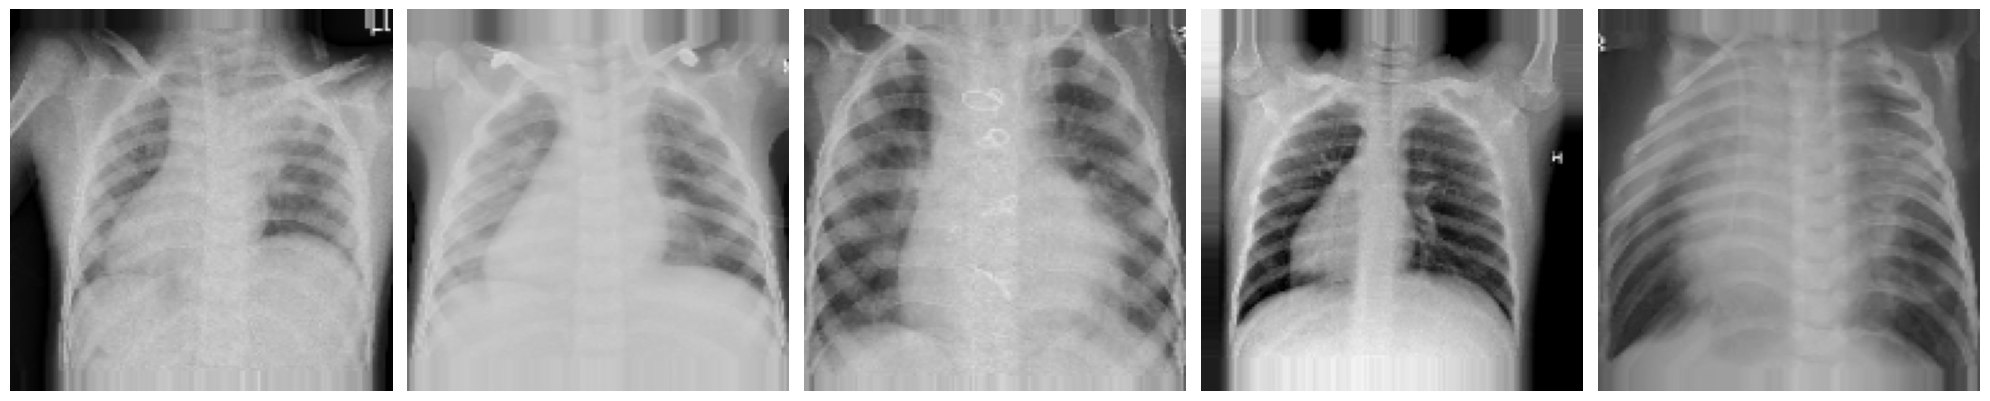

In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch of images
sample_training_images, _ = next(train_generator)

# Plot the images
plot_images(sample_training_images[:5])

# Train the Random Forest Classifier

RandomForestClassifier from sklearn

Hyperparameter tuning is the process of finding the optimal settings for a machine learning model's hyperparameters to improve its performance. Hyperparameters are parameters that are not learned from the data but set prior to the training process. Examples include the learning rate, the number of trees in a Random Forest, and the maximum depth of each tree. Proper tuning of these hyperparameters can significantly affect the accuracy and efficiency of the model.

Steps for Hyperparameter Tuning
Choose Hyperparameters to Tune: Identify which hyperparameters of your model you want to tune. For a Random Forest, typical hyperparameters include:

n_estimators: Number of trees in the forest.
max_depth: Maximum depth of each tree.
min_samples_split: Minimum number of samples required to split an internal node.
min_samples_leaf: Minimum number of samples required to be at a leaf node.
max_features: Number of features to consider when looking for the best split.
Define the Search Space: Determine the range or set of values for each hyperparameter.

Choose a Search Strategy:

Grid Search: Exhaustively searches through a manually specified subset of the hyperparameter space.
Random Search: Samples hyperparameters randomly from a predefined distribution.
Bayesian Optimization: Models the performance of hyperparameters and chooses the next set to evaluate based on previous results.
Automated Machine Learning (AutoML): Uses algorithms to automatically search and tune hyperparameters.
Cross-Validation: Use cross-validation to evaluate the performance of different hyperparameter combinations. This helps in assessing how the model generalizes to an independent dataset.

In [8]:
# Define the parameter grid
param_dist = {
    'n_estimators': [20, 50, 100],
    'max_features': ['sqrt'],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# initialize the random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# perform randomnized search
rf_random = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# fit the model
rf_random.fit(train_data, train_labels)


# Print the best parameters
print(f'Best parameters found: {rf_random.best_params_}')


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time= 3.1min
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time= 3.1min
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time= 3.1min
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time= 3.1min
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20; total time= 3.1min
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time= 3.4min
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 4.1min
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 4.1min
[CV] END max_depth=4, max_features=sqrt, min_samples_lea

# Validate the model using validation dataset

In [11]:
# Evaluate the model with the best parameters
best_rf = rf_random.best_estimator_
best_rf.fit(train_data, train_labels)

# train the model
#rf_clf.fit(train_data, train_labels)

# validate the model
val_predictions = best_rf.predict(val_data)

print("Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print(classification_report(val_labels, val_predictions))

Validation Accuracy: 0.625
              precision    recall  f1-score   support

         0.0       0.75      0.38      0.50         8
         1.0       0.58      0.88      0.70         8

    accuracy                           0.62        16
   macro avg       0.67      0.62      0.60        16
weighted avg       0.67      0.62      0.60        16



# Model evaluation

Evaluate the model using test dataset

In [12]:
test_predictions = best_rf.predict(test_data)

print("Test Accuracy:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.8221153846153846
              precision    recall  f1-score   support

         0.0       0.92      0.58      0.71       234
         1.0       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



# Result and visualization

In [ ]:
"""def visualize_predictions(test_data, test_labels, predictions, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        image = test_data[i].reshape(150, 150)
        plt.imshow(image, cmap='gray')
        plt.title(f'Actual: {test_labels[i]}, Predicted: {predictions[i]}')
        plt.axis('off')
    plt.show()

visualize_predictions(test_data, test_labels, test_predictions)"""